In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import kaggle
import os
import holidays
import tensorflow as tf

2025-02-27 14:20:10.552002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 14:20:10.684707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740687610.742408    4429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740687610.761475    4429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 14:20:10.932593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Model Plan:
- Find a api for real time stock data
- Find a api for real time news
- Feature engineer features
- Build Multi-modal model for day trading.
- First branch of model will be Time Series analysis model that will take the real time stock data as a sequence
- Second branch of model will be a text classifier/sentiment analysis model that can take the real time news
- Combine the two branches to make the multi-modal model

# Agent Plan:
- Use same apis to get input data (This is how agent recieves input)
- Use LLM with function calling to helper function and to run the model (Thinking part)
- Have the agent output the result or make the trade itself using the api (The action/goal achieving part)


## Data Collection

In [2]:
# datasets = [
#     "varpit94/apple-stock-data-updated-till-22jun2021",
#     "prajwaldongre/nvidia-corp-share-price-2000-2024",
#     "varpit94/microsoft-stock-data",
#     "guillemservera/amzn-stock-data",
#     "henryshan/meta-platforms-inc-meta",
#     "henryshan/google-stock-price",
#     "guillemservera/tsla-stock-data"
# ]
# for dataset in datasets: 
#     kaggle.api.dataset_download_files(dataset, path='/home/misha/Desktop/data/day_trader/', unzip=True)

In [3]:
df = pd.DataFrame()
for file in os.listdir('/home/misha/Desktop/data/day_trader/'):
    data = pd.read_csv('/home/misha/Desktop/data/day_trader/' + file)
    data['filename'] = file
    data.columns = [col.strip().title() for col in data.columns]
    df = pd.concat([df, data], axis=0, ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53862 entries, 0 to 53861
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            53862 non-null  object 
 1   Open            53862 non-null  float64
 2   High            53862 non-null  float64
 3   Low             53862 non-null  float64
 4   Close           53862 non-null  float64
 5   Volume          53862 non-null  int64  
 6   Raw_Close       10245 non-null  float64
 7   Change_Percent  20486 non-null  float64
 8   Avg_Vol_20D     20414 non-null  float64
 9   Filename        53862 non-null  object 
 10  Adj Close       33372 non-null  float64
 11  Adjusted_Close  10245 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.9+ MB


In [5]:
df.drop(['Raw_Close', 'Change_Percent', 'Avg_Vol_20D', 'Adjusted_Close', 'Adj Close'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53862 entries, 0 to 53861
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      53862 non-null  object 
 1   Open      53862 non-null  float64
 2   High      53862 non-null  float64
 3   Low       53862 non-null  float64
 4   Close     53862 non-null  float64
 5   Volume    53862 non-null  int64  
 6   Filename  53862 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 2.9+ MB


In [7]:
df.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Filename    0
dtype: int64

In [8]:
filename_to_ticker_map = {
    'tsla_split_adjusted.csv':'TSLA',
    'MSFT.csv':'MSFT',
    'tsla_raw_data.csv':'TSLA',
    'AAPL.csv':'AAPL',
    'META.csv':'META',
    'NVDA.csv':'NVDA',
    'GOOG.csv':'GOOGL',
    'amzn_split_adjusted.csv':'AMZN',
    'amzn_raw_data.csv':'AMZN'
}

In [9]:
df['Ticker'] = df['Filename'].apply(lambda x: filename_to_ticker_map[x])
df.drop('Filename', axis=1, inplace=True)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df['Ticker'].value_counts()

Ticker
AMZN     13546
AAPL     10409
MSFT      9083
TSLA      6944
NVDA      6116
GOOGL     4858
META      2906
Name: count, dtype: int64

In [12]:
df.set_index(['Ticker', 'Date'], inplace=True)
df

Open       High        Low      Close     Volume
Ticker Date                                                             
TSLA   2010-06-29    1.26666    1.66666    1.16934    1.59266  281749173
       2010-06-30    1.71934    2.02794    1.55334    1.58866  257915884
       2010-07-01    1.66666    1.72800    1.35134    1.46400  123447940
       2010-07-02    1.53334    1.54000    1.24734    1.28000   77127102
       2010-07-06    1.33334    1.33334    1.05534    1.07400  103189435
...                      ...        ...        ...        ...        ...
AMZN   2024-04-09  187.24000  187.34000  184.20000  185.67000   36546953
       2024-04-10  182.76500  186.26990  182.67000  185.95000   35879152
       2024-04-11  186.74000  189.77000  185.51000  189.05000   40020738
       2024-04-12  187.72000  188.38000  185.08000  186.13000   38608848
       2024-04-15  187.42500  188.69000  183.00000  183.62000   48052395

[53862 rows x 5 columns]

## Feature engineering

The target will be a binary classification. 1 means that the close price will be greater than the open price. 0 means that the close price will be smaller than the open price

In [13]:
## Target Variable
df['Target'] = (df['Close'] > df['Open']).astype(int)

### Other indicators/features

In [14]:
## Time based features
df['Day Of Week'] = df.index.get_level_values('Date').dayofweek
df['Month'] = df.index.get_level_values('Date').month
df['Quarter'] = df.index.get_level_values('Date').quarter

In [15]:
## Holiday Proximity (How many days until the next holiday)

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

# Function to calculate proximity to the nearest holiday
def holiday_metrics(date):
    """
    Calculate both days until next holiday and days to closest holiday.
    
    Args:
        date: datetime object representing the date to check
        
    Returns:
        tuple: (days_until_next, days_to_closest)
            - days_until_next: number of days until the next upcoming holiday
            - days_to_closest: number of days to the nearest holiday in any direction
    """
    # Generate holidays for current and next year
    us_holidays = holidays.US(years=[date.year, date.year + 1])
    holiday_dates = pd.to_datetime(list(us_holidays.keys()))
    
    # For next holiday
    future_holidays = holiday_dates[holiday_dates > date]
    if len(future_holidays) > 0:
        next_holiday = future_holidays.min()
        days_until_next = (next_holiday - date).days
    else:
        days_until_next = np.nan
    
    # For closest holiday
    if len(holiday_dates) > 0:
        days_diff = np.abs((holiday_dates - date).days)
        days_to_closest = np.min(days_diff)
    else:
        days_to_closest = np.nan
        
    return days_until_next, days_to_closest

# Apply the function to each row
df['Days Until Next Holiday'], df['Days To Closest Holiday'] = zip(*df['Date'].apply(holiday_metrics))

# Set the index back to Ticker and Date if needed
df.set_index(['Ticker', 'Date'], inplace=True)

In [16]:
df['Daily Return'] = (df['Close'] - df['Open']) / df['Open']
df['Intraday Range %'] = (df['High'] - df['Low']) / df['Open']
df['Prev_Close'] = df.groupby('Ticker')['Close'].shift(1)
df['Gap %'] = (df['Open'] - df['Prev_Close']) / df['Prev_Close']
df['Volume Change %'] = df.groupby('Ticker')['Volume'].pct_change()
df['Volume MA 5'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(window=5).mean())
df['SMA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
df['SMA10'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())
df['Above SMA5'] = (df['Close'] > df['SMA5']).astype(int)
df['Volatility 5d'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).std())
df['Price Range %'] = (df['High'] - df['Low']) / df['Open']

In [17]:
## Remove Null values
# Fill forward for values that depend on previous data
df['Prev_Close'] = df.groupby('Ticker')['Prev_Close'].ffill()
df['Gap %'] = df.groupby('Ticker')['Gap %'].ffill()

# Fill first row Volume Change % with 0
df['Volume Change %'] = df['Volume Change %'].fillna(0)

# Fill rolling-based values with their first available mean
rolling_features = ['Volume MA 5', 'SMA5', 'SMA10', 'Volatility 5d']
for feature in rolling_features:
    df[feature] = df.groupby('Ticker')[feature].transform(lambda x: x.fillna(x.expanding().mean()))

# Fill any remaining NaNs (just in case)
df = df.fillna(0)


## Data Preperation

Keep in mind that the final day in the series should NOT have the close feature.

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [19]:
df = df.reset_index()
df.drop('Date', axis=1, inplace=True)

In [20]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [21]:
ticker_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
tickers_encoded = pd.DataFrame(ticker_encoder.fit_transform(df['Ticker'].values.reshape(-1, 1)),
                               columns=ticker_encoder.get_feature_names_out())
df = pd.concat([df, tickers_encoded], axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53862 entries, 0 to 53861
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ticker                   53862 non-null  object 
 1   Open                     53862 non-null  float64
 2   High                     53862 non-null  float64
 3   Low                      53862 non-null  float64
 4   Close                    53862 non-null  float64
 5   Volume                   53862 non-null  int64  
 6   Target                   53862 non-null  int64  
 7   Day Of Week              53862 non-null  int32  
 8   Month                    53862 non-null  int32  
 9   Quarter                  53862 non-null  int32  
 10  Days Until Next Holiday  53862 non-null  int64  
 11  Days To Closest Holiday  53862 non-null  int64  
 12  Daily Return             53862 non-null  float64
 13  Intraday Range %         53862 non-null  float64
 14  Prev_Close            

In [23]:
features = [
    "Open", "High", "Low", "Close", "Volume", "Day Of Week", "Month", "Quarter",
    "Days Until Next Holiday", "Intraday Range %", "Prev_Close", "Gap %", 
    "Volume Change %", "Volume MA 5", "SMA5", "SMA10", "Above SMA5", "Volatility 5d", 
    "Price Range %", "x0_AAPL", "x0_AMZN", "x0_GOOGL", "x0_META", 
    "x0_MSFT", "x0_NVDA", "x0_TSLA"
]

In [24]:
X = df[features].values
y = df['Target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

scaler = StandardScaler()

X_train = np.array(scaler.fit_transform(X_train))
X_test = np.array(scaler.transform(X_test))
X_val = np.array(scaler.transform(X_val))

In [25]:
seq_len = 10

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    targets=y_train,
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=1,
)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_val,
    targets=y_val,
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=1
)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    targets=y_test,
    sequence_length=seq_len,
    batch_size=32,
)

I0000 00:00:1740687642.761012    4429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [26]:
val_ds.element_spec

(TensorSpec(shape=(None, None, 26), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [27]:
for batch in val_ds.take(1):  # Take just one batch for inspection
    sequences, targets = batch
    print("Shape of sequences:", sequences.shape)
    print("Shape of targets:", targets.shape)
    print("Sample sequence:\n", sequences.numpy()[0])  # Print the first sequence in the batch
    print("Sample target:\n", targets.numpy()[0])      # Print the first target in the batch

Shape of sequences: (32, 10, 26)
Shape of targets: (32,)
Sample sequence:
 [[-0.33260559 -0.33327206 -0.33212507 -0.3328067  -0.38861426 -1.44404995
   0.13277207  0.43492695  0.60176155 -0.21531634 -0.33278794 -0.04423498
  -0.41101388 -0.28578973 -0.33286689 -0.33288663  0.92901368 -0.18824827
  -0.21531634 -0.49023275 -0.57977104 -0.31595321 -0.23985106  2.22557046
  -0.35646831 -0.38446803]
 [ 0.67093416  0.66134262  0.67717614  0.66841725 -0.58559339 -0.01479376
  -0.74177813 -0.46115068  0.51691019 -0.89241225  0.67287692 -0.10298987
  -0.38457864 -0.63863407  0.66901144  0.6592559   0.92901368 -0.11554585
  -0.89241225 -0.49023275  1.72481883 -0.31595321 -0.23985106 -0.449323
  -0.35646831 -0.38446803]
 [-0.119634   -0.11704187 -0.11826725 -0.11449531 -0.55179967  1.41446243
  -0.15874466 -0.46115068 -0.88313728  0.13342216 -0.11883641 -0.22375812
   0.1024824  -0.6083795  -0.12339911 -0.12045708  0.92901368 -0.01627521
   0.13342216 -0.49023275  1.72481883 -0.31595321 -0.239851

2025-02-27 14:20:43.725048: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model 

In [28]:
basic_rnn = tf.keras.Sequential([
    tf.keras.layers.Input((10, 26)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
basic_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])
history = basic_rnn.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100


I0000 00:00:1740687644.717800    4567 service.cc:148] XLA service 0x7190a0017390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740687644.717952    4567 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-27 14:20:44.750175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740687644.822895    4567 cuda_dnn.cc:529] Loaded cuDNN version 90300


  90/1347 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4994 - loss: 0.7984

I0000 00:00:1740687645.088742    4567 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1347/1347 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5007 - loss: 0.7366 - val_accuracy: 0.5077 - val_loss: 0.6995
Epoch 2/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5055 - loss: 0.6986 - val_accuracy: 0.5099 - val_loss: 0.6970
Epoch 3/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5072 - loss: 0.6958 - val_accuracy: 0.5085 - val_loss: 0.6959
Epoch 4/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5108 - loss: 0.6943 - val_accuracy: 0.5139 - val_loss: 0.6951
Epoch 5/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5168 - loss: 0.6934 - val_accuracy: 0.5126 - val_loss: 0.6947
Epoch 6/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5170 - loss: 0.6927 - val_accuracy: 0.5155 - val_loss: 0.6944
Epoch 7/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5211 - loss: 0.6921 - val_accuracy: 0.5165 - val_loss: 0.6941
Epoch 8/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5228 - loss: 0.6916 - val_

In [29]:
test_loss, test_acc = basic_rnn.evaluate(test_ds)
print(f"{round(test_acc * 100, 2)}% Accuracy")

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7175 - loss: 0.5824 
71.68% Accuracy


In [30]:
deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input((10, 26)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=2, activation='relu'),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
deep_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])
history = deep_rnn.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5512 - loss: 0.6897 - val_accuracy: 0.6937 - val_loss: 0.6187
Epoch 2/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6974 - loss: 0.6111 - val_accuracy: 0.7071 - val_loss: 0.6012
Epoch 3/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7064 - loss: 0.5978 - val_accuracy: 0.7073 - val_loss: 0.5955
Epoch 4/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7082 - loss: 0.5907 - val_accuracy: 0.7089 - val_loss: 0.5914
Epoch 5/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7096 - loss: 0.5854 - val_accuracy: 0.7088 - val_loss: 0.5882
Epoch 6/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7107 - loss: 0.5812 - val_accuracy: 0.7101 - val_loss: 0.5857
Epoch 7/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7118 - loss: 0.5776 - val_accuracy: 0.7093 - val_loss: 0.5838
Epoch 8/100
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7116 - loss: 0

<Axes: >

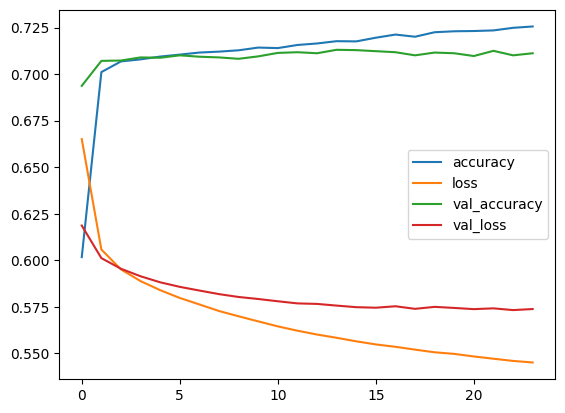

In [31]:
pd.DataFrame(history.history).plot()

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)
deep_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])
history = deep_rnn.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7185 - loss: 0.5562 - val_accuracy: 0.7119 - val_loss: 0.5751
Epoch 2/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7194 - loss: 0.5550 - val_accuracy: 0.7129 - val_loss: 0.5750
Epoch 3/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7201 - loss: 0.5552 - val_accuracy: 0.7121 - val_loss: 0.5750
Epoch 4/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7202 - loss: 0.5547 - val_accuracy: 0.7115 - val_loss: 0.5750
Epoch 5/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7200 - loss: 0.5545 - val_accuracy: 0.7115 - val_loss: 0.5750
Epoch 6/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7204 - loss: 0.5544 - val_accuracy: 0.7121 - val_loss: 0.5750
Epoch 7/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7207 - loss: 0.5542 - val_accuracy: 0.7121 - val_loss: 0.5750
Epoch 8/50
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7208 - loss: 0.5537 - 

<Axes: >

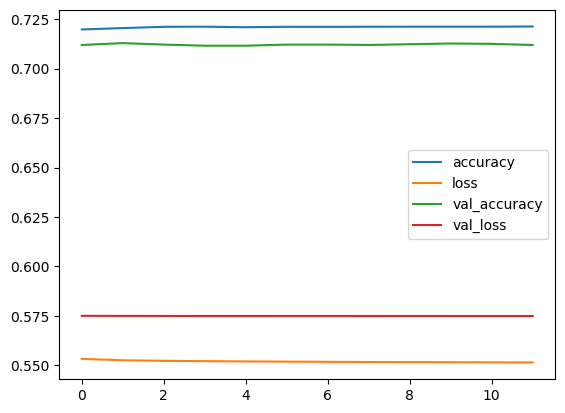

In [33]:
pd.DataFrame(history.history).plot()

### Fine Tune Model

In [34]:
import keras_tuner as kt

In [ ]:
def build_model(hp: kt.HyperParameters):
    ## Hyperparameters
    num_rnn_layers = hp.Int('n_rnn_layers', min_value=1, max_value=5)
    n_neurons = hp.Int()

    ## Model